In [95]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor


In [2]:
df = pd.read_csv('steam_user.csv')
print (df.head())

   151603712  The Elder Scrolls V Skyrim  purchase    1.0  0
0  151603712  The Elder Scrolls V Skyrim      play  273.0  0
1  151603712                   Fallout 4  purchase    1.0  0
2  151603712                   Fallout 4      play   87.0  0
3  151603712                       Spore  purchase    1.0  0
4  151603712                       Spore      play   14.9  0


In [3]:
# Присваиваем названия колонкам
df.columns = ['user_id', 'game_name', 'action', 'play_hours', 'to_delete']

# Удаляем пятую колонку
df = df.drop(columns=['to_delete'])

# Считаем уникальные значения для user_id и game_name
unique_user_ids = df['user_id'].nunique()
unique_game_names = df['game_name'].nunique()

# Выводим результаты
print(f"Уникальные user_id: {unique_user_ids}")
print(f"Уникальные game_name: {unique_game_names}")

Уникальные user_id: 12393
Уникальные game_name: 5155


In [4]:
game_df = pd.read_csv('games.csv')

In [5]:
game_df

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065230,Room of Pandora,2019-04-24,1,SHEN JIAWEI,SHEN JIAWEI,windows,0,Single-player;Steam Achievements,Adventure;Casual;Indie,Adventure;Indie;Casual,7,3,0,0,0,0-20000,2.09
27071,1065570,Cyber Gun,2019-04-23,1,Semyon Maximov,BekkerDev Studio,windows,0,Single-player,Action;Adventure;Indie,Action;Indie;Adventure,0,8,1,0,0,0-20000,1.69
27072,1065650,Super Star Blast,2019-04-24,1,EntwicklerX,EntwicklerX,windows,0,Single-player;Multi-player;Co-op;Shared/Split ...,Action;Casual;Indie,Action;Indie;Casual,24,0,1,0,0,0-20000,3.99
27073,1066700,New Yankee 7: Deer Hunters,2019-04-17,1,Yustas Game Studio,Alawar Entertainment,windows;mac,0,Single-player;Steam Cloud,Adventure;Casual;Indie,Indie;Casual;Adventure,0,2,0,0,0,0-20000,5.19


In [6]:
merged_df = pd.merge(df, game_df, left_on='game_name', right_on='name', how='inner')

In [7]:
merged_df.shape

(92883, 22)

In [8]:
merged_df.isna().sum()

user_id              0
game_name            0
action               0
play_hours           0
appid                0
name                 0
release_date         0
english              0
developer            0
publisher           11
platforms            0
required_age         0
categories           0
genres               0
steamspy_tags        0
achievements         0
positive_ratings     0
negative_ratings     0
average_playtime     0
median_playtime      0
owners               0
price                0
dtype: int64

In [10]:
unique_user_ids = merged_df['user_id'].nunique()
unique_game_names = merged_df['game_name'].nunique()

# Выводим результаты
print(f"Уникальные user_id: {unique_user_ids}")
print(f"Уникальные game_name: {unique_game_names}")

Уникальные user_id: 10121
Уникальные game_name: 2190


In [11]:
df = merged_df.drop(columns=['game_name'])

In [13]:
df['publisher'].fillna('unknown', inplace=True)

In [14]:
df.isna().sum()

user_id             0
action              0
play_hours          0
appid               0
name                0
release_date        0
english             0
developer           0
publisher           0
platforms           0
required_age        0
categories          0
genres              0
steamspy_tags       0
achievements        0
positive_ratings    0
negative_ratings    0
average_playtime    0
median_playtime     0
owners              0
price               0
dtype: int64

In [15]:
multi_value_columns = ['genres', 'categories', 'steamspy_tags']

def split_and_create_dummies(df, column, separator=';', prefix=None):
    split_data = df[column].str.get_dummies(sep=separator)
    
    if prefix:
        split_data = split_data.add_prefix(f'{prefix}_')
    
    df = pd.concat([df, split_data], axis=1)
    return df

for col in multi_value_columns:
    df = split_and_create_dummies(df, col, separator=';', prefix=col)

df.head()

,user_id,action,play_hours,appid,name,release_date,english,developer,publisher,platforms,...,steamspy_tags_War,steamspy_tags_Wargame,steamspy_tags_Warhammer 40K,steamspy_tags_Web Publishing,steamspy_tags_Werewolves,steamspy_tags_Western,steamspy_tags_Word Game,steamspy_tags_World War I,steamspy_tags_World War II,steamspy_tags_Zombies
0,151603712,purchase,1.0,377160,Fallout 4,2015-11-09,1,Bethesda Game Studios,Bethesda Softworks,windows,...,0,0,0,0,0,0,0,0,0,0
1,151603712,play,87.0,377160,Fallout 4,2015-11-09,1,Bethesda Game Studios,Bethesda Softworks,windows,...,0,0,0,0,0,0,0,0,0,0
2,151603712,purchase,1.0,550,Left 4 Dead 2,2009-11-19,1,Valve,Valve,windows;mac;linux,...,0,0,0,0,0,0,0,0,0,1
3,151603712,play,8.9,550,Left 4 Dead 2,2009-11-19,1,Valve,Valve,windows;mac;linux,...,0,0,0,0,0,0,0,0,0,1
4,151603712,purchase,1.0,339800,HuniePop,2015-01-19,1,HuniePot,HuniePot,windows;mac;linux,...,0,0,0,0,0,0,0,0,0,0


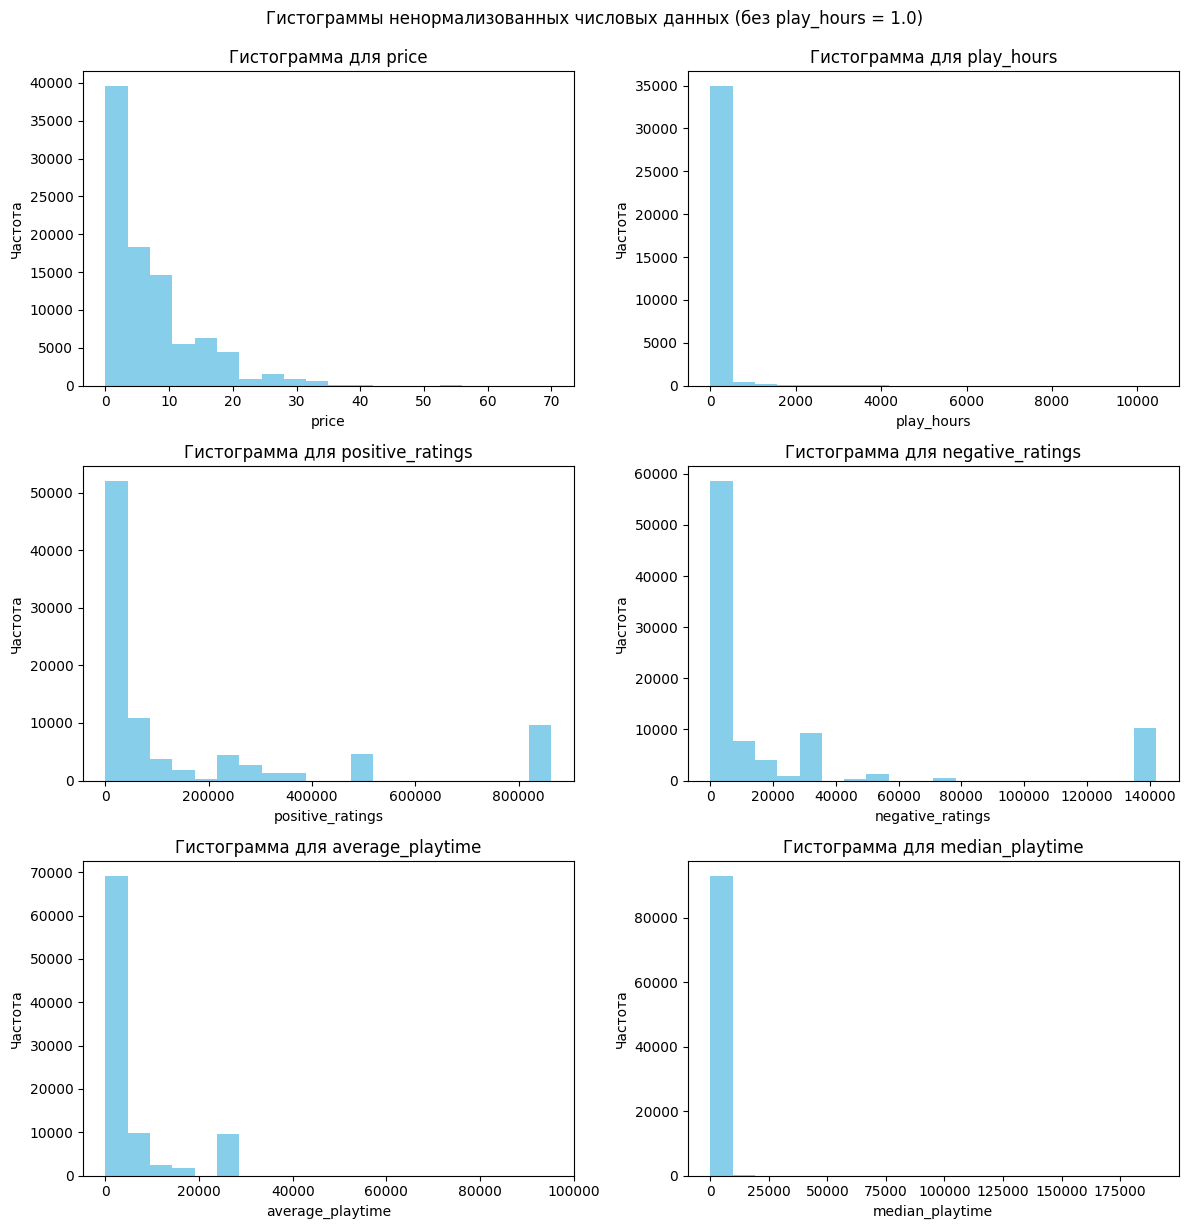

In [16]:
numerical_columns = ['price', 'play_hours', 'positive_ratings', 'negative_ratings', 'average_playtime', 'median_playtime']
df['price'] = pd.to_numeric(df['price'].replace('[\$,]', '', regex=True), errors='coerce')

fig, axes = plt.subplots(3, 2, figsize=(12, 12))  # 3 ряда, 2 колонки
axes = axes.ravel()

for i, col in enumerate(numerical_columns):
    if col == 'play_hours':
        # Исключаем значения, равные 1.0 (это покупка)
        data = df[col][df[col] != 1.0].dropna()
    else:
        data = df[col].dropna()
    
    axes[i].hist(data, bins=20, color='skyblue')
    axes[i].set_title(f"Гистограмма для {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Частота")

plt.tight_layout()
plt.suptitle("Гистограммы ненормализованных числовых данных (без play_hours = 1.0)", y=1.02)
plt.show()



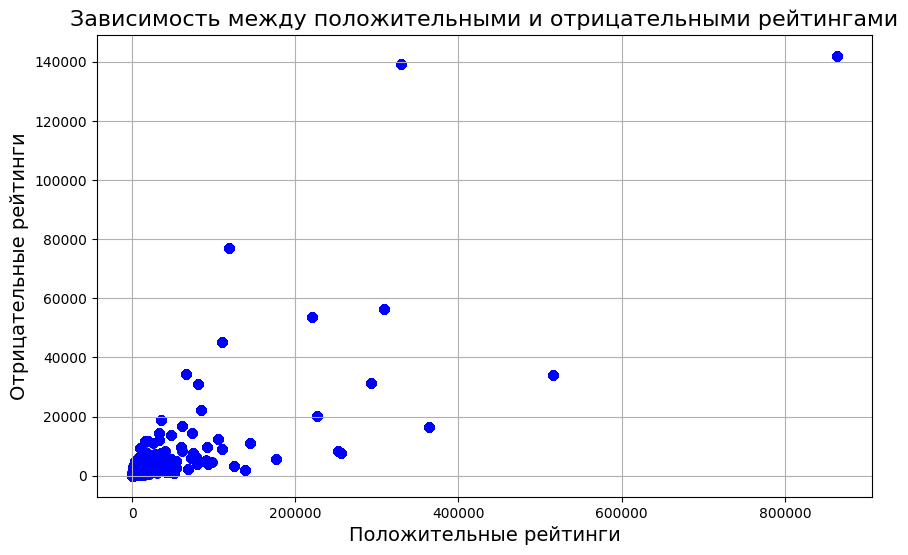

In [17]:
plt.figure(figsize=(10, 6))

plt.scatter(df['positive_ratings'], df['negative_ratings'], alpha=0.5, color='blue')

plt.title('Зависимость между положительными и отрицательными рейтингами', fontsize=16)
plt.xlabel('Положительные рейтинги', fontsize=14)
plt.ylabel('Отрицательные рейтинги', fontsize=14)
plt.grid(True)

plt.show()


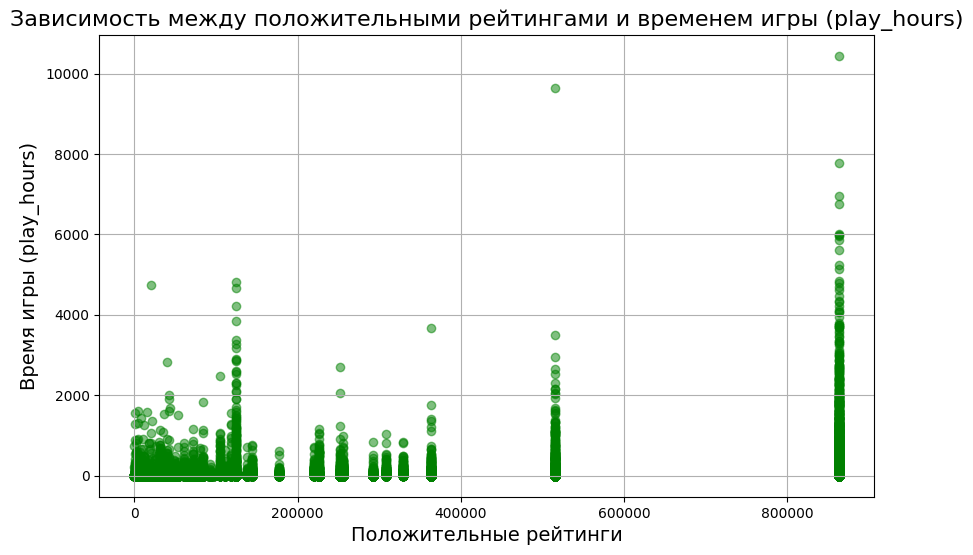

In [18]:
filtered_df = df[df['play_hours'] != 1.0]

plt.figure(figsize=(10, 6))

plt.scatter(filtered_df['positive_ratings'], filtered_df['play_hours'], alpha=0.5, color='green')

plt.title('Зависимость между положительными рейтингами и временем игры (play_hours)', fontsize=16)
plt.xlabel('Положительные рейтинги', fontsize=14)
plt.ylabel('Время игры (play_hours)', fontsize=14)
plt.grid(True)

plt.show()



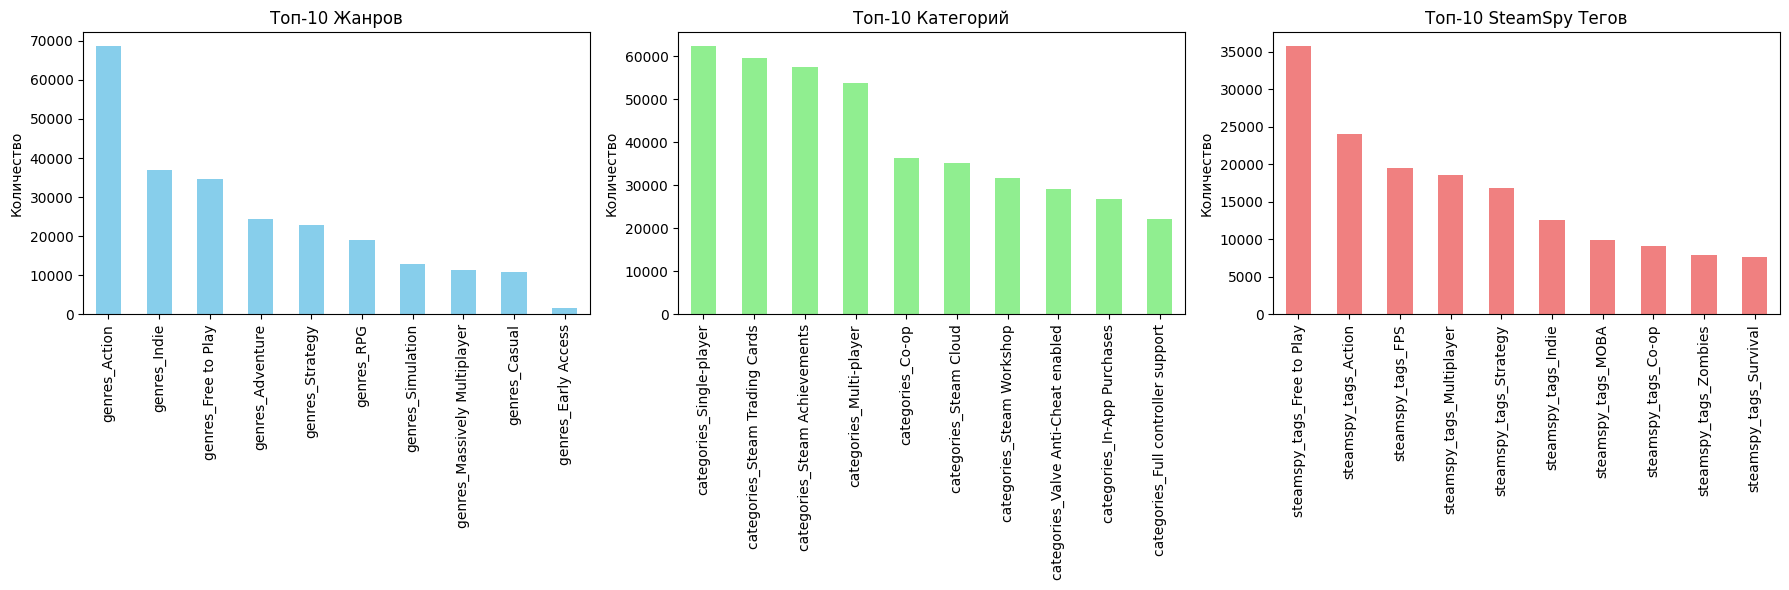

In [19]:
top_genres = df.filter(like='genres_').sum().sort_values(ascending=False).head(10)
top_categories = df.filter(like='categories_').sum().sort_values(ascending=False).head(10)
top_tags = df.filter(like='steamspy_tags_').sum().sort_values(ascending=False).head(10)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Три подграфика в один ряд

top_genres.plot(kind='bar', ax=axes[0], color='skyblue', title='Топ-10 Жанров')
axes[0].set_ylabel('Количество')

top_categories.plot(kind='bar', ax=axes[1], color='lightgreen', title='Топ-10 Категорий')
axes[1].set_ylabel('Количество')

top_tags.plot(kind='bar', ax=axes[2], color='lightcoral', title='Топ-10 SteamSpy Тегов')
axes[2].set_ylabel('Количество')

plt.tight_layout()
plt.show()

In [20]:
df.drop(columns=df.filter(like='steamspy_tags_').columns)

,user_id,action,play_hours,appid,name,release_date,english,developer,publisher,platforms,...,categories_Stats,categories_Steam Achievements,categories_Steam Cloud,categories_Steam Leaderboards,categories_Steam Trading Cards,categories_Steam Turn Notifications,categories_Steam Workshop,categories_SteamVR Collectibles,categories_VR Support,categories_Valve Anti-Cheat enabled
0,151603712,purchase,1.0,377160,Fallout 4,2015-11-09,1,Bethesda Game Studios,Bethesda Softworks,windows,...,0,1,1,0,0,0,0,0,0,0
1,151603712,play,87.0,377160,Fallout 4,2015-11-09,1,Bethesda Game Studios,Bethesda Softworks,windows,...,0,1,1,0,0,0,0,0,0,0
2,151603712,purchase,1.0,550,Left 4 Dead 2,2009-11-19,1,Valve,Valve,windows;mac;linux,...,1,1,1,0,1,0,1,0,0,1
3,151603712,play,8.9,550,Left 4 Dead 2,2009-11-19,1,Valve,Valve,windows;mac;linux,...,1,1,1,0,1,0,1,0,0,1
4,151603712,purchase,1.0,339800,HuniePop,2015-01-19,1,HuniePot,HuniePot,windows;mac;linux,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92878,128470551,play,1.5,297130,Titan Souls,2015-04-14,1,Acid Nerve,Devolver Digital,windows;mac,...,0,1,0,0,0,0,0,0,0,0
92879,128470551,purchase,1.0,38720,RUSH,2010-12-03,1,Two Tribes,Two Tribes Publishing,windows;mac;linux,...,0,1,1,0,0,0,0,0,0,0
92880,128470551,purchase,1.0,844040,RUSH,2018-07-13,1,The Binary Mill,The Binary Mill,windows,...,0,1,1,1,0,0,0,0,0,0
92881,128470551,play,1.4,38720,RUSH,2010-12-03,1,Two Tribes,Two Tribes Publishing,windows;mac;linux,...,0,1,1,0,0,0,0,0,0,0


In [34]:
import requests
import pandas as pd
import numpy as np
import time

# Функция для получения информации о цене игры из Steam Store API
def fetch_steam_prices(app_ids):
    app_ids_str = ','.join(map(str, app_ids))  # Соединяем ID через запятую
    url = f'http://store.steampowered.com/api/appdetails?appids={app_ids_str}&cc=us&filters=price_overview'
    try:
        response = requests.get(url)
        data = response.json()
        return data
    except Exception as e:
        print(f"Error fetching data: {e}")
        return {}

# Функция для парсинга данных о ценах
def parse_prices(data):
    price_data = []
    for appid, details in data.items():
        if details['success'] and 'price_overview' in details['data']:
            price_info = details['data']['price_overview']
            price_data.append({
                'appid': appid,
                'initial_price': price_info['initial'] / 100,
                'final_price': price_info['final'] / 100,
                'discount_percent': price_info['discount_percent']
            })
        else:
            price_data.append({
                'appid': appid,
                'initial_price': np.nan,
                'final_price': np.nan,
                'discount_percent': np.nan
            })
    return price_data

# Получаем все уникальные item_id из DataFrame
item_ids = df['appid'].unique()

# Список для хранения результатов
price_data = []

# Определяем размер батча
batch_size = 10

# Проходим по item_id батчами
for i in range(0, len(item_ids), batch_size):
    batch = item_ids[i:i + batch_size]
    prices = fetch_steam_prices(batch)
    price_data.extend(parse_prices(prices))
    
    # Задержка для предотвращения превышения лимитов Steam API
    time.sleep(1)

# Преобразуем результат в DataFrame
price_df = pd.DataFrame(price_data)

# Выводим результат
price_df.head()


,appid,initial_price,final_price,discount_percent
0,377160,19.99,19.99,0.0
1,550,9.99,9.99,0.0
2,339800,9.99,9.99,0.0
3,238960,NaN,NaN,NaN
4,367450,9.99,9.99,0.0


In [155]:
price_df = pd.read_csv('steam_prices.csv')

In [156]:
price_df.isna().sum()

appid                 0
initial_price       367
final_price         367
discount_percent    367
dtype: int64

In [157]:
df['price'] = price_df['initial_price'].combine_first(df['price'])

In [158]:
string_columns = df.select_dtypes(include=['object']).columns
print(string_columns)

Index(['name'], dtype='object')


In [159]:
#обработка категориальных признаков
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')  # Преобразуем в datetime
df['release_year'] = df['release_date'].dt.year  # Извлекаем год

# 2. Преобразование платформ в бинарные индикаторы
# Если платформа поддерживается, ставим 1, иначе 0
df['platform_windows'] = df['platforms'].apply(lambda x: 1 if 'windows' in x.lower() else 0)
df['platform_mac'] = df['platforms'].apply(lambda x: 1 if 'mac' in x.lower() else 0)
df['platform_linux'] = df['platforms'].apply(lambda x: 1 if 'linux' in x.lower() else 0)

# 3. Преобразование диапазонов пользователей в среднее значение
def parse_owners(owners_range):
    if pd.isna(owners_range):  # Проверяем на NaN
        return np.nan
    # Разбиваем диапазон и считаем среднее
    range_values = owners_range.split('-')
    if len(range_values) == 2:
        low = int(range_values[0].replace(',', ''))
        high = int(range_values[1].replace(',', ''))
        return (low + high) / 2
    else:
        return np.nan  # Если формат не подходит

# Применяем функцию для преобразования колонок 'owners'
df['estimated_owners'] = df['owners'].apply(parse_owners)

# Удаляем старые колонки, которые были преобразованы
df.drop(columns=['platforms', 'release_date', 'owners'], inplace=True)

# Выводим первые строки преобразованного DataFrame
print(df.head())


KeyError: 'release_date'

In [26]:
df = df.drop(columns=df.filter(like='steamspy_tags_').columns)

In [34]:
df.columns

Index(['user_id', 'action', 'play_hours', 'appid', 'name', 'english',
       'developer', 'publisher', 'required_age', 'categories', 'genres',
       'steamspy_tags', 'achievements', 'positive_ratings', 'negative_ratings',
       'average_playtime', 'median_playtime', 'price', 'genres_Action',
       'genres_Adventure', 'genres_Animation & Modeling', 'genres_Casual',
       'genres_Design & Illustration', 'genres_Early Access',
       'genres_Education', 'genres_Free to Play', 'genres_Game Development',
       'genres_Gore', 'genres_Indie', 'genres_Massively Multiplayer',
       'genres_Nudity', 'genres_Photo Editing', 'genres_RPG', 'genres_Racing',
       'genres_Sexual Content', 'genres_Simulation',
       'genres_Software Training', 'genres_Sports', 'genres_Strategy',
       'genres_Utilities', 'genres_Video Production', 'genres_Violent',
       'genres_Web Publishing', 'categories_Captions available',
       'categories_Co-op', 'categories_Commentary available',
       'categories_

In [27]:
df = df[['user_id', 'action', 'play_hours', 'appid', 'name', 'english',
         'developer', 'publisher', 'required_age',
         'achievements', 'positive_ratings', 'negative_ratings',
         'average_playtime', 'median_playtime', 'price', 'genres_Indie', 'genres_Action', 
         'genres_Adventure', 'genres_Casual', 'genres_Strategy', 'genres_RPG', 
         'genres_Simulation', 'genres_Racing', 'genres_Sports', 'genres_Early Access', 
         'categories_Single-player', 'categories_Steam Trading Cards', 
         'categories_Steam Achievements', 'categories_Steam Cloud', 
         'categories_Full controller support', 'categories_Multi-player', 
         'categories_Steam Leaderboards', 'categories_Partial Controller Support', 
         'categories_Co-op', 'categories_Stats', 'release_year', 'platform_windows', 
         'platform_mac', 'platform_linux', 'estimated_owners']]


In [28]:
string_columns = df.select_dtypes(include=['object']).columns
print(string_columns)

Index(['action', 'name', 'developer', 'publisher'], dtype='object')


In [29]:
# Группируем данные по 'user_id' и 'appid' и проверяем наличие 'purchase' и 'play'
grouped = df.groupby(['user_id', 'appid'])['action'].apply(lambda x: set(x)).reset_index()

grouped['has_purchase_and_play'] = grouped['action'].apply(lambda x: 'purchase' in x and 'play' in x)

only_purchase = grouped[(grouped['action'].apply(lambda x: 'purchase' in x)) & 
                        (~grouped['action'].apply(lambda x: 'play' in x))]

print(only_purchase.head())  # Показывает случаи, где есть 'purchase', но нет 'play'
print(grouped['has_purchase_and_play'].value_counts())  # Считает случаи, где оба действия есть и где нет


   user_id  appid      action  has_purchase_and_play
0     5250     10  {purchase}                  False
1     5250     20  {purchase}                  False
2     5250     30  {purchase}                  False
3     5250     40  {purchase}                  False
4     5250     60  {purchase}                  False
has_purchase_and_play
True     36300
False    20190
Name: count, dtype: int64


In [30]:
# Фильтруем данные, чтобы учитывать только строки, где action == 'play'
play_data = df[df['action'] == 'play']

developer_avg_play_hours = play_data.groupby('developer')['play_hours'].mean().to_dict()
publisher_avg_play_hours = play_data.groupby('publisher')['play_hours'].mean().to_dict()

# Создаем новые колонки для всех строк с средними значениями play_hours, рассчитанными только для action == 'play'
df['developer'] = df['developer'].map(developer_avg_play_hours)
df['publisher'] = df['publisher'].map(publisher_avg_play_hours)

# Проверяем результат
print(df[['developer', 'publisher']].head())


    developer   publisher
0   55.865366   33.888913
1   55.865366   33.888913
2  127.465523  124.345968
3  127.465523  124.345968
4   20.820000   20.820000


In [31]:
df.columns

Index(['user_id', 'action', 'play_hours', 'appid', 'name', 'english',
       'developer', 'publisher', 'required_age', 'achievements',
       'positive_ratings', 'negative_ratings', 'average_playtime',
       'median_playtime', 'price', 'genres_Indie', 'genres_Action',
       'genres_Adventure', 'genres_Casual', 'genres_Strategy', 'genres_RPG',
       'genres_Simulation', 'genres_Racing', 'genres_Sports',
       'genres_Early Access', 'categories_Single-player',
       'categories_Steam Trading Cards', 'categories_Steam Achievements',
       'categories_Steam Cloud', 'categories_Full controller support',
       'categories_Multi-player', 'categories_Steam Leaderboards',
       'categories_Partial Controller Support', 'categories_Co-op',
       'categories_Stats', 'release_year', 'platform_windows', 'platform_mac',
       'platform_linux', 'estimated_owners'],
      dtype='object')

In [32]:
df['action'] = df['action'].map({'play': 1, 'purchase': 2})

In [33]:
# Создаем функцию для агрегирования данных и сбрасываем action
def custom_agg(x):
    d = x.iloc[0]
    d['play_hours'] = x['play_hours'].sum()  
    return d

df_aggregated = df.groupby(['user_id', 'appid']).apply(custom_agg).reset_index(drop=True)

df_aggregated = df_aggregated.drop(columns=['action'])

print(df_aggregated.head())


   user_id  play_hours  appid                   name  english   developer  \
0     5250         1.0     10         Counter-Strike        1  127.465523   
1     5250         1.0     20  Team Fortress Classic        1  127.465523   
2     5250         1.0     30          Day of Defeat        1  127.465523   
3     5250         1.0     40     Deathmatch Classic        1  127.465523   
4     5250         1.0     60               Ricochet        1  127.465523   

    publisher  required_age  achievements  positive_ratings  ...  \
0  124.345968             0             0            124534  ...   
1  124.345968             0             0              3318  ...   
2  124.345968             0             0              3416  ...   
3  124.345968             0             0              1273  ...   
4  124.345968             0             0              2758  ...   

   categories_Multi-player  categories_Steam Leaderboards  \
0                        1                              0   
1     

C:\Users\ereme\AppData\Local\Temp\ipykernel_16428\1151078352.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_aggregated = df.groupby(['user_id', 'appid']).apply(custom_agg).reset_index(drop=True)


In [34]:
df = df_aggregated

Для тестирования модеоли были разделены игры пользователей попалам для каждого пользователя. Игры в которых пользователь проводит больше времени будут в тренировочной выборке, а те, а которых меньше в тесте. Будем проверять способность модели предсказывать данные из теста.  

In [107]:
def split_user_data(user_id, user_data):
    user_data_sorted = user_data.sort_values('play_hours')
    num_games = len(user_data_sorted)
    
    # Проверяем, что у пользователя достаточно игр для разделения
    if num_games >= 2:
        test_size = max(1, num_games // 2)
        train_size = num_games - test_size
        test_data = user_data_sorted.iloc[:test_size]
        train_data = user_data_sorted.iloc[test_size:]
    else:
        test_data = pd.DataFrame(columns=user_data.columns)
        train_data = user_data_sorted
    
    return train_data, test_data

def split_all_users(df):
    user_train_test = {}
    for user_id, user_data in df.groupby('user_id'):
        if len(user_data) >= 2:
            train_data, test_data = split_user_data(user_id, user_data)
            user_train_test[user_id] = {'train': train_data, 'test': test_data}
        else:
            continue 
    return user_train_test

user_train_test = split_all_users(df)



In [109]:
# Собираем все тренировочные данные в один DataFrame
train_data = pd.concat([user_train_test[user]['train'] for user in user_train_test])

# Создаем матрицу взаимодействий (users x items)
user_game_matrix = train_data.pivot_table(index='user_id', columns='appid', values='play_hours', fill_value=0)


In [110]:
# Приводим матрицу к формату numpy array
user_game_matrix_values = user_game_matrix.values

# Инициализируем и обучаем модель KNN
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(user_game_matrix_values)

NearestNeighbors(algorithm='brute', metric='cosine')

In [112]:
def recommend_knn(user_id, user_game_matrix, knn_model, df_train, top_n=3):
    if user_id not in user_game_matrix.index:
        print(f"Пользователь {user_id} отсутствует в тренировочных данных.")
        return []
    
    user_idx = user_game_matrix.index.get_loc(user_id)
    user_vector = user_game_matrix.iloc[user_idx].values.reshape(1, -1)
    
    distances, indices = knn_model.kneighbors(user_vector, n_neighbors=top_n+1)  # +1, чтобы исключить самого пользователя
    
    similar_user_indices = indices.flatten()[1:] 
    similar_users = user_game_matrix.index[similar_user_indices]

    user_games = set(df_train[df_train['user_id'] == user_id]['appid'])
    
    similar_users_games = df[df['user_id'].isin(similar_users)]
    
    recommendations = similar_users_games[~similar_users_games['appid'].isin(user_games)]
    
    game_recommendations = recommendations.groupby('appid')['play_hours'].sum()
    
    recommended_games = game_recommendations.nlargest(top_n).index.tolist()
    return recommended_games


In [113]:
# Пример рекомендации для пользователя
user_id_example = list(user_game_matrix.index)[0] 
recommended_games = recommend_knn(user_id_example, user_game_matrix, knn, train_data, top_n=3)
print(f"Рекомендованные игры для пользователя {user_id_example}: {recommended_games}")


Рекомендованные игры для пользователя 5250: [49520, 304050, 218620]


In [ ]:
Для оценки качества рекомендаций используем метрику Mean Average Precision (MAP), Mean Average Recall (MAR) и Mean Average F1 (MAF1) для ста рандомных пользователей.

In [114]:
def evaluate_recommendations(user_id, recommended_games, user_train_test):
    if 'test' not in user_train_test[user_id] or user_train_test[user_id]['test'].empty:
        return None, None, None  # Нет тестовых данных для оценки
    
    # Получаем список игр из тестового набора пользователя
    user_games = user_train_test[user_id]['test']['appid'].unique()
    if len(user_games) == 0:
        return None, None, None  # Нет игр в тестовом наборе

    # Пересечение рекомендованных игр с тестовыми играми пользователя
    true_positives = set(recommended_games).intersection(set(user_games))
    tp = len(true_positives)
    total_recommended = len(recommended_games)
    total_actual = len(user_games)

    precision = tp / total_recommended if total_recommended > 0 else 0
    recall = tp / total_actual if total_actual > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1


In [115]:
random_users = random.sample(list(user_game_matrix.index), 100)

precision_knn, recall_knn, f1_knn = [], [], []

for user_id in random_users:
    # Получаем рекомендации для пользователя
    recommended_games = recommend_knn(user_id, user_game_matrix, knn, train_data, top_n=3)

    # Оцениваем рекомендации
    precision, recall, f1 = evaluate_recommendations(user_id, recommended_games, user_train_test)

    if precision is not None:
        precision_knn.append(precision)
        recall_knn.append(recall)
        f1_knn.append(f1)


In [116]:
if len(precision_knn) > 0:
    avg_precision_knn = np.mean(precision_knn)
    avg_recall_knn = np.mean(recall_knn)
    avg_f1_knn = np.mean(f1_knn)

    print(f"KNN - Average Precision: {avg_precision_knn:.4f}")
    print(f"KNN - Average Recall: {avg_recall_knn:.4f}")
    print(f"KNN - Average F1-score: {avg_f1_knn:.4f}")
else:
    print("Не удалось вычислить метрики: недостаточно данных для оценки.")


KNN - Average Precision: 0.1967
KNN - Average Recall: 0.2898
KNN - Average F1-score: 0.2127


In [117]:
# Матрица взаимодействий пользователей и игр (используем тренировочные данные)
user_game_matrix = train_data.pivot_table(index='user_id', columns='appid', values='play_hours', fill_value=0)

In [118]:
# Транспонируем матрицу, чтобы строки соответствовали играм
game_user_matrix = user_game_matrix.T

# Расчет косинусного сходства между играми
item_similarity = cosine_similarity(game_user_matrix)
item_similarity_df = pd.DataFrame(item_similarity, index=game_user_matrix.index, columns=game_user_matrix.index)


In [119]:
game_user_matrix

user_id,5250,76767,86540,103360,144736,181212,229911,298950,299153,381543,...,307288211,307674833,307688442,307729778,308468736,308695132,308760273,309052991,309181805,309404240
appid,,,,,,,,,,,,,,,,,,,,,
10,0.0,366.0,0.0,0.0,1.1,2.8,46.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
776080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
844040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [120]:
def recommend_item_based(user_id, user_game_matrix, item_similarity_df, df_train, top_n=3):
    if user_id not in user_game_matrix.index:
        print(f"Пользователь {user_id} отсутствует в тренировочных данных.")
        return []
    
    # Получаем игры, в которые пользователь уже играл
    user_games = user_game_matrix.loc[user_id]
    user_games = user_games[user_games > 0].index.tolist()
    
    # Словарь для хранения суммарного сходства
    scores = {}
    for game in user_games:
        # Получаем сходство текущей игры с другими играми
        similar_games = item_similarity_df[game]
        # Проходим по каждой игре и суммируем сходства
        for sim_game, score in similar_games.items():
            if sim_game in user_games:
                continue  # Пропускаем игры, в которые пользователь уже играл
            if sim_game not in scores:
                scores[sim_game] = score
            else:
                scores[sim_game] += score
    
    # Сортируем игры по суммарному сходству
    sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    recommended_games = [game for game, score in sorted_scores][:top_n]
    
    return recommended_games


In [122]:
random_users = random.sample(list(user_game_matrix.index), 100)

precision_item_based, recall_item_based, f1_item_based = [], [], []

for user_id in random_users:
    # Получаем рекомендации для пользователя
    recommended_games = recommend_item_based(user_id, user_game_matrix, item_similarity_df, train_data, top_n=3)
    
    # Оцениваем рекомендации
    precision, recall, f1 = evaluate_recommendations(user_id, recommended_games, user_train_test)
    
    # Проверяем, что оценка возможна
    if precision is not None:
        precision_item_based.append(precision)
        recall_item_based.append(recall)
        f1_item_based.append(f1)


In [123]:
if len(precision_item_based) > 0:
    avg_precision_item_based = np.mean(precision_item_based)
    avg_recall_item_based = np.mean(recall_item_based)
    avg_f1_item_based = np.mean(f1_item_based)
    
    print(f"Item-Based CF - Average Precision: {avg_precision_item_based:.4f}")
    print(f"Item-Based CF - Average Recall: {avg_recall_item_based:.4f}")
    print(f"Item-Based CF - Average F1-score: {avg_f1_item_based:.4f}")
else:
    print("Не удалось вычислить метрики: недостаточно данных для оценки.")


Item-Based CF - Average Precision: 0.0667
Item-Based CF - Average Recall: 0.0646
Item-Based CF - Average F1-score: 0.0564


In [124]:
# Подготовка данных для библиотеки Surprise
reader = Reader(rating_scale=(0, train_data['play_hours'].max()))
data = Dataset.load_from_df(train_data[['user_id', 'appid', 'play_hours']], reader)

# Разделение данных на тренировочные и тестовые
trainset = data.build_full_trainset()

In [125]:
# обучение модели SVD
svd_model = SVD()
svd_model.fit(trainset)


In [126]:
def recommend_svd(user_id, svd_model, df_train, top_n=3):
    all_games = df_train['appid'].unique()
    user_games = set(df_train[df_train['user_id'] == user_id]['appid'])
    games_to_predict = [game for game in all_games if game not in user_games]
    
    predictions = [svd_model.predict(user_id, game) for game in games_to_predict]
    predictions.sort(key=lambda x: x.est, reverse=True)
    recommended_games = [pred.iid for pred in predictions[:top_n]]
    return recommended_games


In [127]:
precision_svd, recall_svd, f1_svd = [], [], []

for user_id in random_users:
    recommended_games = recommend_svd(user_id, svd_model, train_data, top_n=3)
    
    precision, recall, f1 = evaluate_recommendations(user_id, recommended_games, user_train_test)
    
    if precision is not None:
        precision_svd.append(precision)
        recall_svd.append(recall)
        f1_svd.append(f1)


In [129]:
if len(precision_svd) > 0:
    avg_precision_svd = np.mean(precision_svd)
    avg_recall_svd = np.mean(recall_svd)
    avg_f1_svd = np.mean(f1_svd)
    
    print(f"SVD Model - Average Precision: {avg_precision_svd:.4f}")
    print(f"SVD Model - Average Recall: {avg_recall_svd:.4f}")
    print(f"SVD Model - Average F1-score: {avg_f1_svd:.4f}")
else:
    print("Не удалось вычислить метрики: недостаточно данных для оценки.")


SVD Model - Average Precision: 0.0933
SVD Model - Average Recall: 0.1131
SVD Model - Average F1-score: 0.0798
